# Latency analysis charts

Этот ноутбук строит графики по latency-файлам `latencies/conn_*.lat`:

- Временной ряд латентности для каждого соединения (по индексу сообщений)
- Гистограммы распределений
- CDF (эмпирические функции распределения) в одном графике для сравнения
- Boxplot/Violin plot по соединениям
- Роллинговые перцентили p50/p90/p99 по окну сообщений

Файлы ищутся автоматически по маске `../latencies/conn_*.lat` (запускать из папки `charts/`).


In [24]:
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

plt.style.use('seaborn-v0_8-darkgrid')

# discover files (robust to notebooks where __file__ is undefined)
base = Path(__file__).resolve(
).parent if '__file__' in globals() else Path.cwd()
lat_dir = (base.parent / 'latencies')
if not lat_dir.exists():
    lat_dir = Path.cwd() / 'latencies'
files = sorted(lat_dir.glob('conn_*.lat'))
print(f"Using lat_dir={lat_dir}")
print(f"Found {len(files)} files")
files


Using lat_dir=/home/rama/webhook-parsing/latencies
Found 10 files


[PosixPath('/home/rama/webhook-parsing/latencies/conn_0_20250904_222303.lat'),
 PosixPath('/home/rama/webhook-parsing/latencies/conn_0_20250904_222342.lat'),
 PosixPath('/home/rama/webhook-parsing/latencies/conn_0_20250904_222412.lat'),
 PosixPath('/home/rama/webhook-parsing/latencies/conn_0_20250904_222444.lat'),
 PosixPath('/home/rama/webhook-parsing/latencies/conn_1_20250904_222342.lat'),
 PosixPath('/home/rama/webhook-parsing/latencies/conn_1_20250904_222412.lat'),
 PosixPath('/home/rama/webhook-parsing/latencies/conn_1_20250904_222444.lat'),
 PosixPath('/home/rama/webhook-parsing/latencies/conn_2_20250904_222412.lat'),
 PosixPath('/home/rama/webhook-parsing/latencies/conn_2_20250904_222444.lat'),
 PosixPath('/home/rama/webhook-parsing/latencies/conn_3_20250904_222444.lat')]

In [25]:
# Load data into a dict of DataFrames: {conn_id: df}
series = {}
for p in files:
    # parse connection index from filename
    stem = p.stem  # conn_<idx>_<ts>
    try:
        conn_id = int(stem.split('_')[1])
    except Exception:
        continue
    arr = np.loadtxt(p, dtype=float, ndmin=1)
    # ensure 1D
    arr = np.atleast_1d(arr)
    series[conn_id] = pd.DataFrame({
        'lat_ms': arr,
        'idx': np.arange(arr.shape[0]),
        'conn': conn_id,
    })

len(series), [k for k in series.keys()]


(4, [0, 1, 2, 3])

In [26]:
# Concatenate for joint plots
if series:
    df = pd.concat(series.values(), ignore_index=True)
else:
    df = pd.DataFrame(columns=['lat_ms', 'idx', 'conn'])

df.describe(percentiles=[.5, .9, .99])


,lat_ms,idx,conn
count,14337.000000,14337.000000,14337.000000
mean,704.899770,1791.626700,1.500105
std,88.569251,1034.722842,1.118042
min,643.000000,0.000000,0.000000
50%,655.000000,1792.000000,1.000000
90%,845.000000,3225.000000,3.000000
99%,964.640000,3548.000000,3.000000
max,998.000000,3588.000000,3.000000


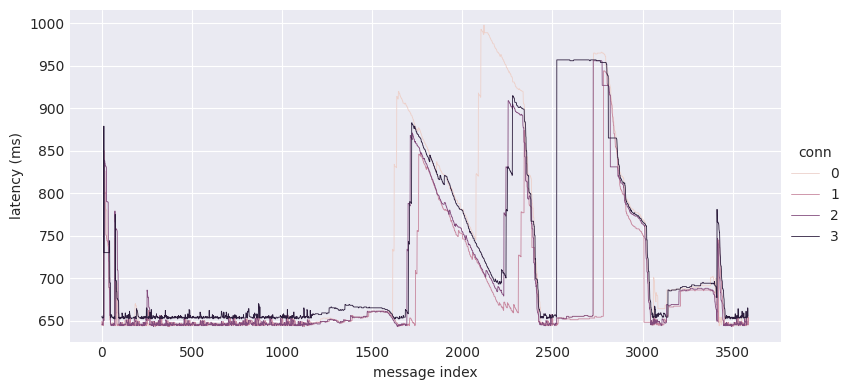

In [27]:
# Time series per connection (index-space)
if not df.empty:
    g = sns.relplot(data=df, x='idx', y='lat_ms', hue='conn',
                    kind='line', height=4, aspect=2, linewidth=0.6)
    g.set_axis_labels('message index', 'latency (ms)')
    plt.show()
else:
    print('No data')


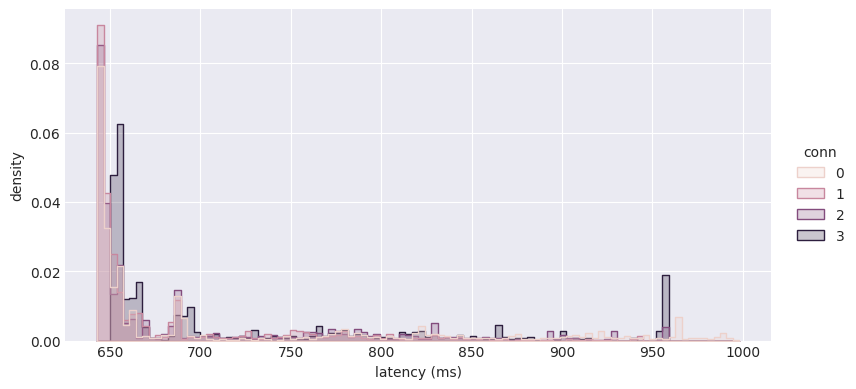

In [28]:
# Histograms per connection
if not df.empty:
    g = sns.displot(data=df, x='lat_ms', hue='conn', kind='hist', bins=100,
                    height=4, aspect=2, element='step', stat='density', common_norm=False)
    g.set_axis_labels('latency (ms)', 'density')
    plt.show()
else:
    print('No data')


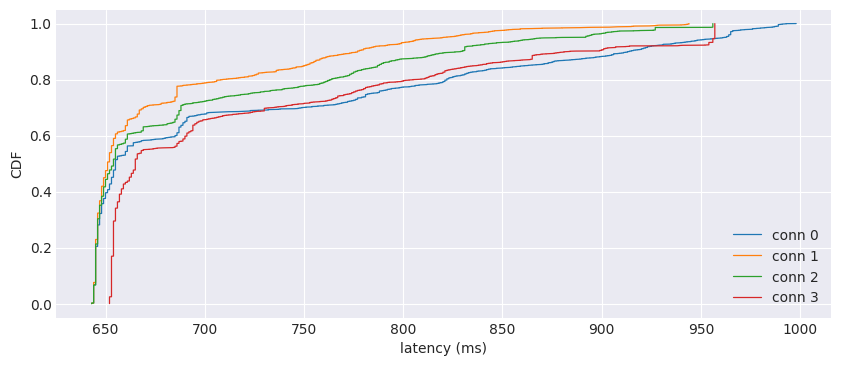

In [29]:
# Empirical CDF per connection
if not df.empty:
    plt.figure(figsize=(10, 4))
    for conn_id, d in df.groupby('conn'):
        x = np.sort(d['lat_ms'].values)
        y = np.linspace(0, 1, len(x), endpoint=False)
        plt.plot(x, y, label=f'conn {conn_id}', linewidth=0.9)
    plt.xlabel('latency (ms)')
    plt.ylabel('CDF')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print('No data')


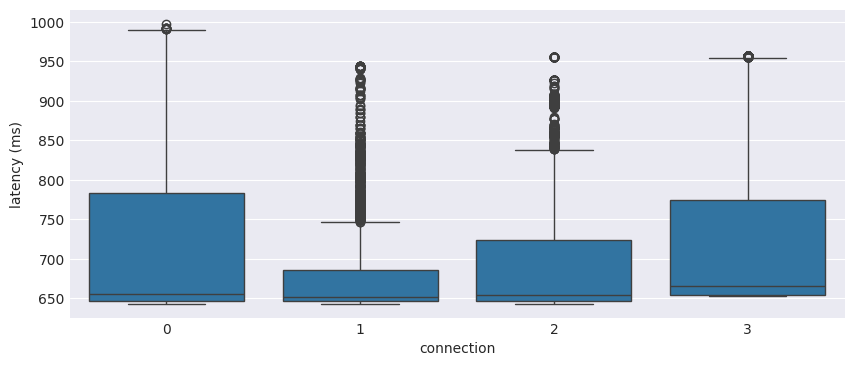

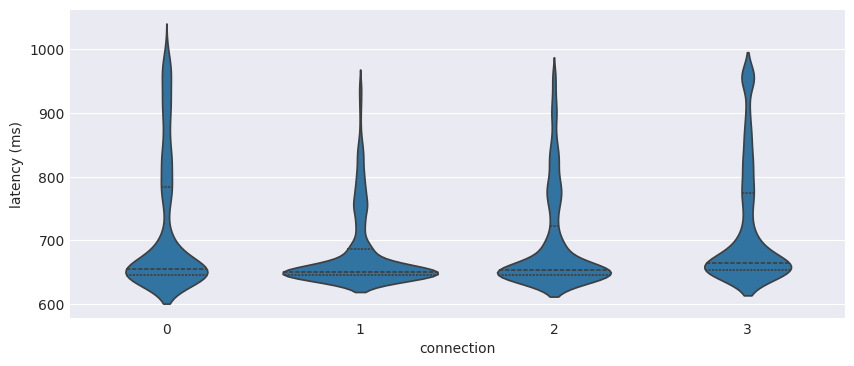

In [30]:
# Box/violin plot per connection
if not df.empty:
    plt.figure(figsize=(10, 4))
    sns.boxplot(data=df, x='conn', y='lat_ms')
    plt.xlabel('connection')
    plt.ylabel('latency (ms)')
    plt.show()

    plt.figure(figsize=(10, 4))
    sns.violinplot(data=df, x='conn', y='lat_ms',
                   inner='quartile', bw_method=0.2)
    plt.xlabel('connection')
    plt.ylabel('latency (ms)')
    plt.show()
else:
    print('No data')


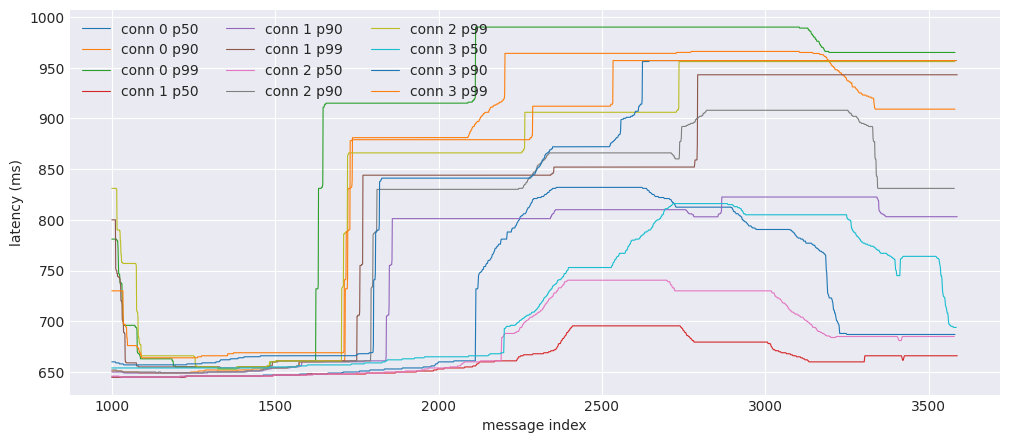

In [31]:
# Rolling percentiles (p50/p90/p99) per connection
# Use a window in messages, e.g., 1000
win = 1000
if not df.empty:
    plt.figure(figsize=(12, 5))
    for conn_id, d in df.groupby('conn'):
        v = d['lat_ms'].values
        if len(v) < win:
            continue
        s = pd.Series(v)
        p50 = s.rolling(win).quantile(0.50)
        p90 = s.rolling(win).quantile(0.90)
        p99 = s.rolling(win).quantile(0.99)
        plt.plot(p50.values, label=f'conn {conn_id} p50', linewidth=0.8)
        plt.plot(p90.values, label=f'conn {conn_id} p90', linewidth=0.8)
        plt.plot(p99.values, label=f'conn {conn_id} p99', linewidth=0.8)
    plt.xlabel('message index')
    plt.ylabel('latency (ms)')
    plt.legend(ncol=3)
    plt.show()
else:
    print('No data')


## Universal multi-source loader (async per-connection, sync, python)

Парсит несколько типов источников:
- C++ async per-connection: `conn_<idx>_<YYYYMMDD_HHMMSS>.lat`
- C++ sync (опционально): `sync_<YYYYMMDD_HHMMSS>.lat`
- Python (один поток): `python_*.log` (один latency на строку)

Результат — словарь `{(run_ts, series_id): np.array}` где `series_id` — строка вида `conn:0`, `conn:1`, `sync`, `python`.


In [32]:
from datetime import datetime


def parse_async_conn(p: Path):
    # conn_<idx>_<YYYYMMDD_HHMMSS>.lat
    parts = p.stem.split('_')
    if len(parts) < 3:
        return None
    conn = int(parts[1])
    ts = parts[2]
    if len(parts) >= 4:
        ts = parts[2] + '_' + parts[3]
    run_ts = datetime.strptime(
        ts, "%Y%m%d_%H%M%S") if '_' in ts else datetime.strptime(ts, "%Y%m%d")
    arr = np.loadtxt(p, dtype=float, ndmin=1)
    return (run_ts, f"conn:{conn}"), np.atleast_1d(arr)


def parse_sync(p: Path):
    # sync_<YYYYMMDD_HHMMSS>.lat
    if not p.stem.startswith('sync_'):
        return None
    ts = p.stem[len('sync_'):]
    run_ts = datetime.strptime(ts, "%Y%m%d_%H%M%S")
    arr = np.loadtxt(p, dtype=float, ndmin=1)
    return (run_ts, 'sync'), np.atleast_1d(arr)


def parse_python(p: Path):
    # python_*.log (one latency per line)
    if not p.stem.startswith('python_'):
        return None
    # best-effort timestamp from mtime
    run_ts = datetime.fromtimestamp(p.stat().st_mtime)
    arr = np.loadtxt(p, dtype=float, ndmin=1)
    return (run_ts, 'python'), np.atleast_1d(arr)


sources = {}
# Async per-connection
for p in files:
    r = parse_async_conn(p)
    if r:
        sources[r[0]] = r[1]
# Optional sync
for p in sorted(lat_dir.glob('sync_*.lat')):
    r = parse_sync(p)
    if r:
        sources[r[0]] = r[1]
# Optional python
for p in sorted(lat_dir.glob('python_*.log')):
    try:
        r = parse_python(p)
        if r:
            sources[r[0]] = r[1]
    except Exception:
        pass

len(sources)


10

In [33]:
# Build per-run, per-series stats table
rows = []
for (run_ts, series_id), arr in sources.items():
    if arr.size == 0:
        continue
    rows.append({
        'run_ts': run_ts,
        'series': series_id,
        'count': int(arr.size),
        'p50': float(np.percentile(arr, 50)),
        'p90': float(np.percentile(arr, 90)),
        'p99': float(np.percentile(arr, 99)),
        'p999': float(np.percentile(arr, 99.9)),
        'max': float(arr.max()),
    })
stats = pd.DataFrame(rows).sort_values(
    ['run_ts', 'series']).reset_index(drop=True)
stats.head()


,run_ts,series,count,p50,p90,p99,p999,max
0,2025-09-04 22:23:03,conn:0,3739,658.0,978.0,991.00,1034.000,1035.0
1,2025-09-04 22:23:42,conn:0,3676,660.0,967.0,1013.00,1041.325,1091.0
2,2025-09-04 22:23:42,conn:1,3675,662.0,948.0,1064.00,1225.304,1255.0
3,2025-09-04 22:24:12,conn:0,4294,659.0,836.0,862.00,864.000,881.0
4,2025-09-04 22:24:12,conn:1,4340,655.0,665.0,771.61,819.661,822.0


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


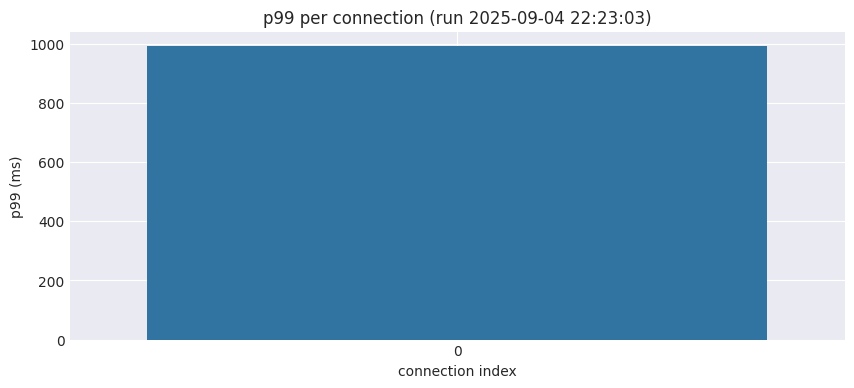

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


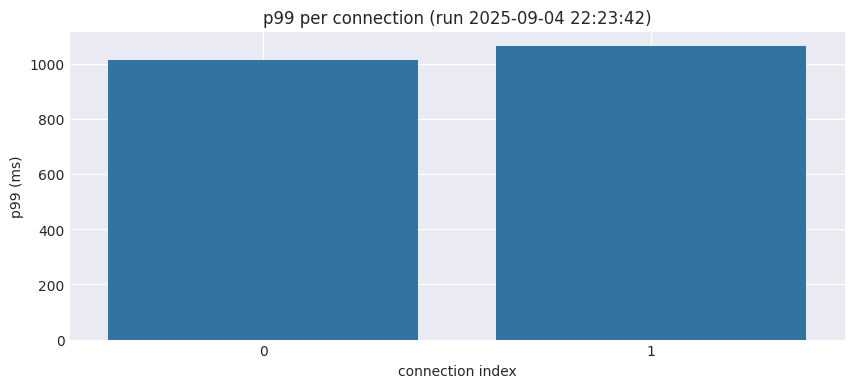

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


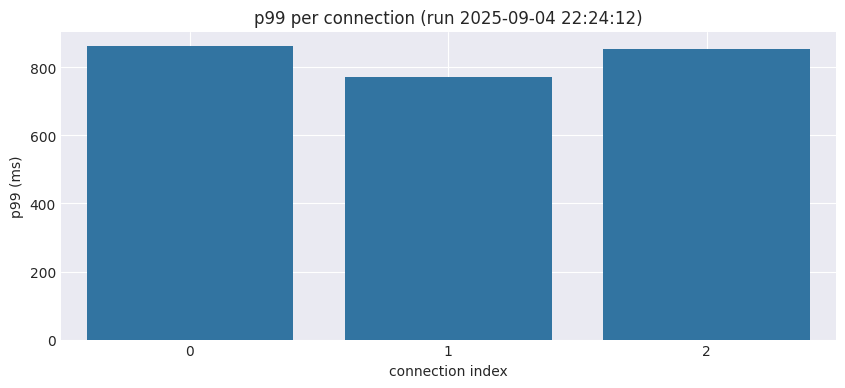

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


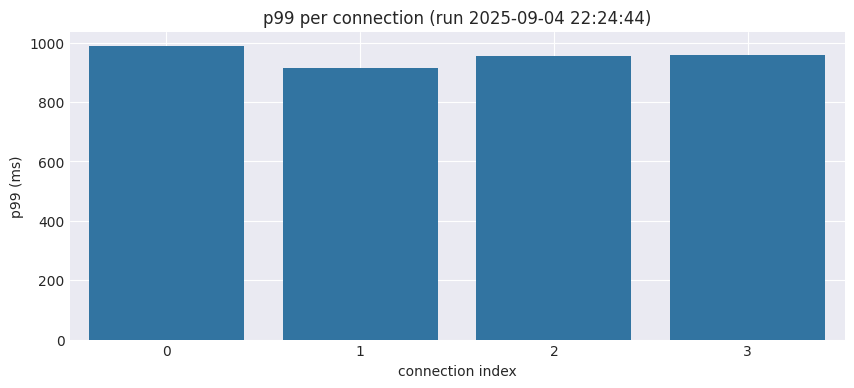

In [34]:
# p99/p999 vs number of connections K (per run), including python/sync if present
from collections import defaultdict

if stats.empty:
    print('No stats')
else:
    for run_ts, g in stats.groupby('run_ts'):
        # identify async connections
        conn_rows = g[g['series'].str.startswith('conn:')].copy()
        conn_rows['conn_idx'] = conn_rows['series'].str.split(
            ':').str[1].astype(int)
        # plot per-run per-series p99
        plt.figure(figsize=(10, 4))
        sns.barplot(data=conn_rows.sort_values('conn_idx'),
                    x='conn_idx', y='p99', color='tab:blue')
        if not g[g['series'] == 'sync'].empty:
            plt.axhline(g[g['series'] == 'sync']['p99'].values[0],
                        color='tab:orange', linestyle='--', label='sync p99')
        if not g[g['series'] == 'python'].empty:
            plt.axhline(g[g['series'] == 'python']['p99'].values[0],
                        color='tab:green', linestyle='--', label='python p99')
        plt.title(f'p99 per connection (run {run_ts})')
        plt.xlabel('connection index')
        plt.ylabel('p99 (ms)')
        plt.legend()
        plt.grid(True)
        plt.show()


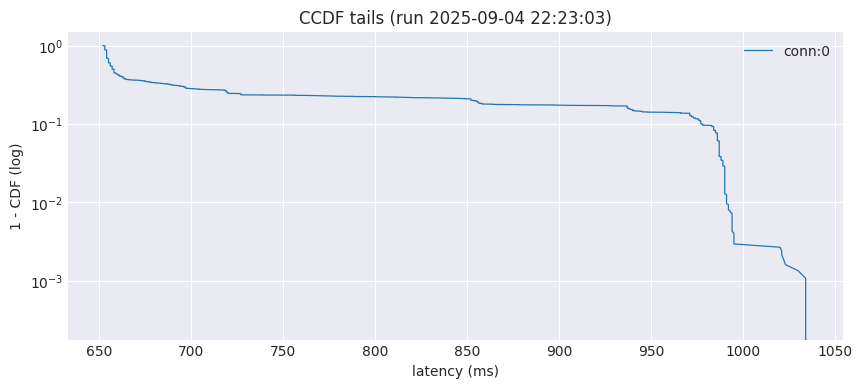

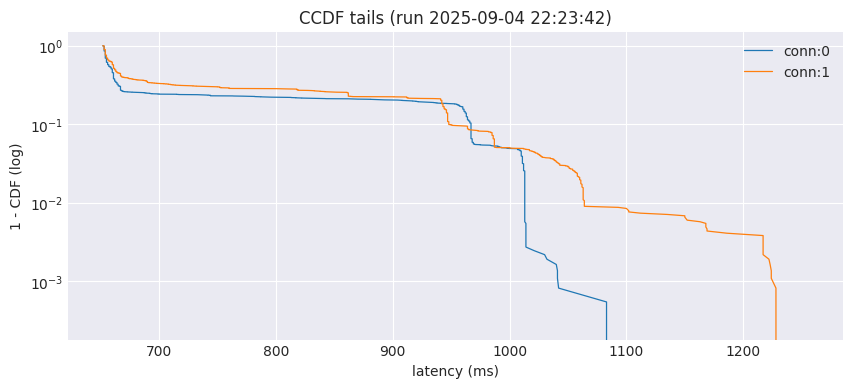

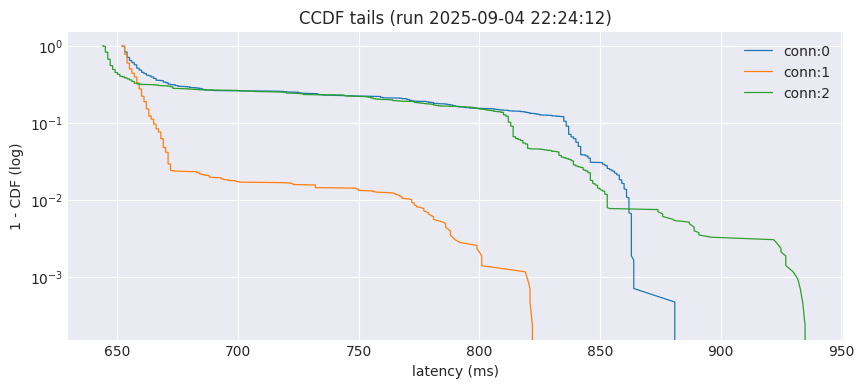

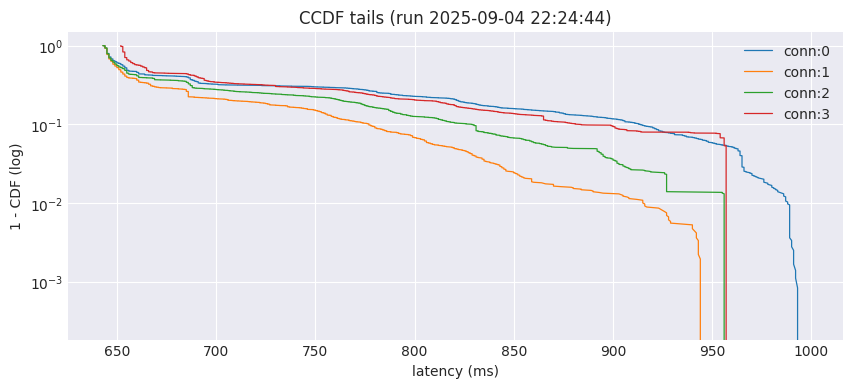

In [35]:
# CCDF tails per run and per connection (log Y)
if sources:
    for run_ts in sorted({k[0] for k in sources.keys()}):
        # collect series for this run
        items = [(sid, arr) for (ts, sid), arr in sources.items()
                 if ts == run_ts and sid.startswith('conn:')]
        if not items:
            continue
        plt.figure(figsize=(10, 4))
        for sid, arr in sorted(items):
            x = np.sort(arr)
            y = 1.0 - np.arange(1, len(x)+1) / len(x)
            plt.plot(x, y, label=sid, linewidth=0.9)
        # reference lines
        base = stats[(stats['run_ts'] == run_ts)]
        if not base[base['series'] == 'sync'].empty:
            plt.axvline(base[base['series'] == 'sync']['p99'].values[0],
                        color='tab:orange', linestyle='--', alpha=0.6)
        if not base[base['series'] == 'python'].empty:
            plt.axvline(base[base['series'] == 'python']['p99'].values[0],
                        color='tab:green', linestyle='--', alpha=0.6)
        plt.yscale('log')
        plt.xlabel('latency (ms)')
        plt.ylabel('1 - CDF (log)')
        plt.title(f'CCDF tails (run {run_ts})')
        plt.legend()
        plt.grid(True)
        plt.show()
else:
    print('No sources')


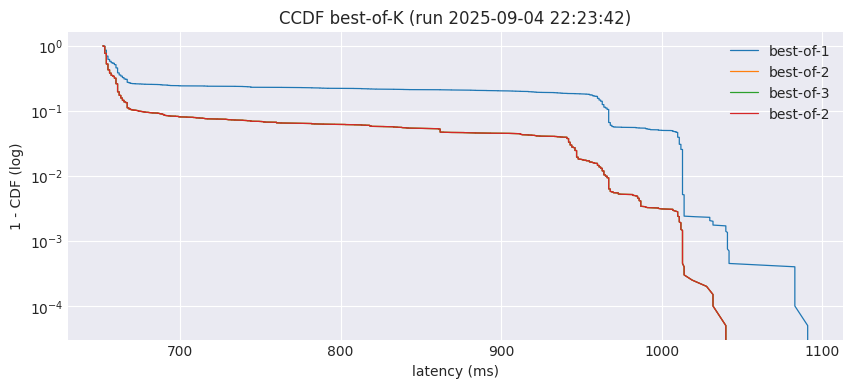

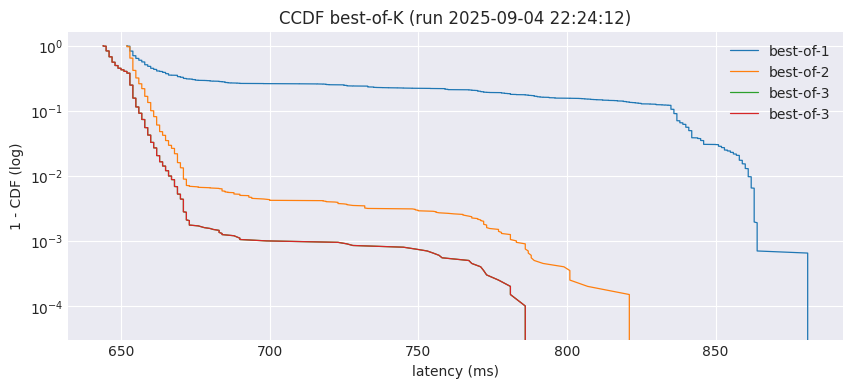

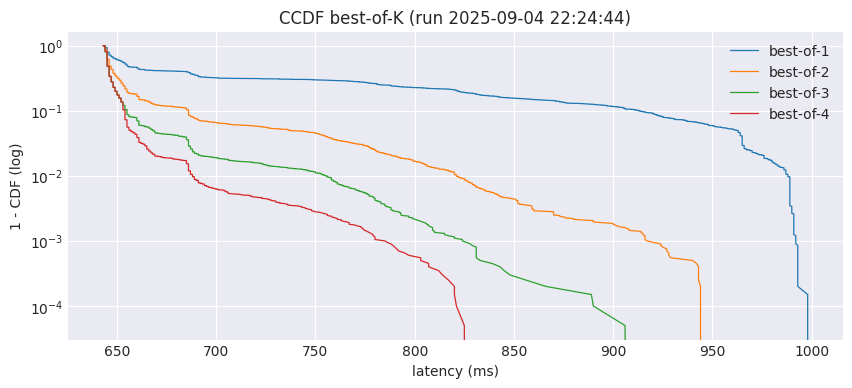

In [36]:
# Best-of-K (synthetic min across K connections) for a given run
# Shows how tails improve when taking the min across multiple independent conns
import random


def best_of_k(arrays, K, draws=20000):
    arrays = arrays[:K]
    if not arrays:
        return np.array([])
    rng = np.random.default_rng(42)
    out = np.empty(draws, dtype=float)
    sizes = [len(a) for a in arrays]
    for i in range(draws):
        vals = [a[rng.integers(0, sz)] for a, sz in zip(arrays, sizes)]
        out[i] = min(vals)
    return out


if sources:
    for run_ts in sorted({k[0] for k in sources.keys()}):
        # gather only async conn arrays
        items = [(sid, arr) for (ts, sid), arr in sources.items()
                 if ts == run_ts and sid.startswith('conn:')]
        if len(items) < 2:
            continue
        arrays = [arr for _, arr in sorted(items)]
        plt.figure(figsize=(10, 4))
        for K in [1, 2, 3, min(4, len(arrays))]:
            bo = best_of_k(arrays, K)
            if bo.size == 0:
                continue
            x = np.sort(bo)
            y = 1.0 - np.arange(1, len(x)+1)/len(x)
            plt.plot(x, y, label=f'best-of-{K}', linewidth=0.9)
        plt.yscale('log')
        plt.xlabel('latency (ms)')
        plt.ylabel('1 - CDF (log)')
        plt.title(f'CCDF best-of-K (run {run_ts})')
        plt.legend()
        plt.grid(True)
        plt.show()
else:
    print('No sources')
